# Tutorial: Joint Node Classification and Link Prediction in Citation Networks

## Applying Graph Machine Learning to Academic Paper Analysis

**Authors**: Denis Troegubov  
**Date**: December 2025  
**GitHub**: [Link](https://github.com/BogGoro/predicting-paper-topics-and-connections-tutorial)

---

## Introduction

Welcome to this hands-on tutorial on Graph Machine Learning! In this notebook, we'll explore how to apply state-of-the-art Graph Neural Networks (GNNs) to solve two fundamental problems in citation networks:

1. **Node Classification**: Predicting research topics of academic papers
2. **Link Prediction**: Recommending potential citations between papers

We'll use the **Cora dataset** - a classic benchmark in graph ML - and implement our models using **PyTorch Geometric (PyG)**, the leading library for deep learning on graphs.

### Why This Tutorial?
- **Practical Approach**: We focus on real-world applications rather than theory
- **Code-First**: Learn by implementing working models
- **Production-Ready**: Code structured for reproducibility and extension

### Prerequisites
- Basic knowledge of Python and PyTorch
- Understanding of neural networks
- No prior experience with graphs required!

Let's get started!

1. Environment Setup

In [ ]:
# Install PyTorch Geometric and dependencies
!pip install -q torch torchvision torchaudio
!pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install -q torch-geometric
!pip install -q matplotlib networkx seaborn

In [1]:
# Import libraries
import torch
import torch.nn.functional as F
import torch.nn as nn

# PyTorch Geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import SAGEConv, GCNConv
from torch_geometric.utils import negative_sampling, to_networkx
from torch_geometric.data import Data

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
from sklearn.manifold import TSNE

# Utilities
import warnings

warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✅ Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

c:\Users\troye\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: Could not find module 'C:\Users\troye\AppData\Local\Programs\Python\Python312\Lib\site-packages\libpyg.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
c:\Users\troye\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] Не найдена указанная процедура
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\troye\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] Не найдена указанная п

✅ Libraries imported successfully!
PyTorch version: 2.8.0+cpu
CUDA available: False


## 2. Understanding the Data: Cora Dataset

### What is Cora?
The Cora dataset is a classic citation network consisting of machine learning papers. It's widely used as a benchmark in graph ML research.

### Dataset Statistics:
- **Nodes**: 2,708 academic papers
- **Edges**: 10,556 citation links (directed)
- **Features**: 1,433-dimensional binary word vectors (bag-of-words)
- **Classes**: 7 research topics

📊 Dataset Information:
Dataset: Cora()
Number of graphs: 1
Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Number of classes: 7
Has isolated nodes: False
Has self-loops: False
Is undirected: True


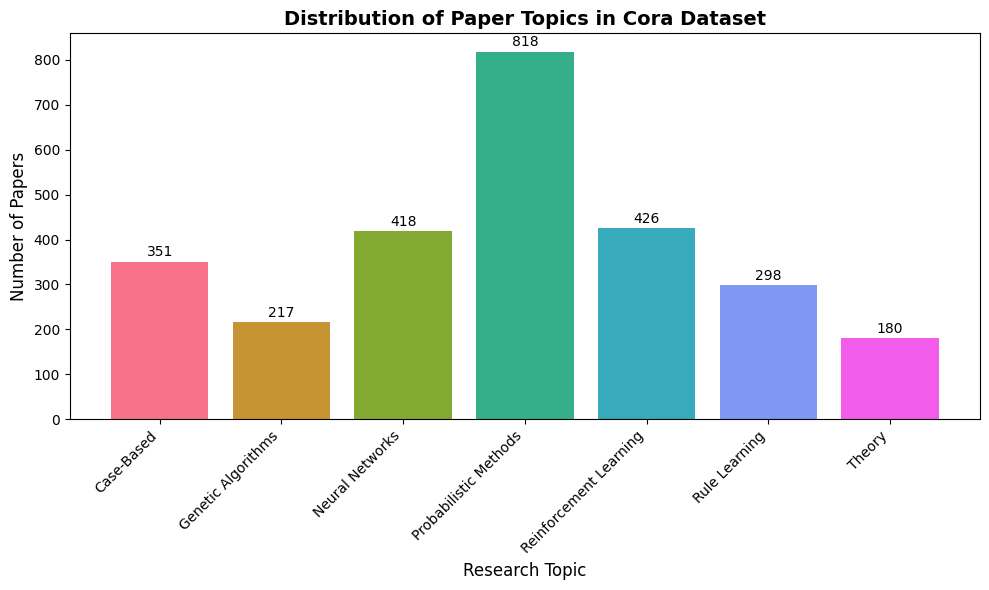

In [ ]:
# Load the Cora dataset
dataset = Planetoid(root="/tmp/Cora", name="Cora")
data = dataset[0]

print("📊 Dataset Information:")
print("=" * 40)
print(f"Dataset: {dataset}")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of features: {data.num_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Has isolated nodes: {data.has_isolated_nodes()}")
print(f"Has self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

# %%
# Visualize the class distribution
class_names = [
    "Case-Based",
    "Genetic Algorithms",
    "Neural Networks",
    "Probabilistic Methods",
    "Reinforcement Learning",
    "Rule Learning",
    "Theory",
]

class_counts = torch.bincount(data.y).numpy()

plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, class_counts, color=sns.color_palette("husl", 7))
plt.title(
    "Distribution of Paper Topics in Cora Dataset", fontsize=14, fontweight="bold"
)
plt.xlabel("Research Topic", fontsize=12)
plt.ylabel("Number of Papers", fontsize=12)
plt.xticks(rotation=45, ha="right")

# Add count labels on bars
for bar, count in zip(bars, class_counts):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 5,
        f"{count}",
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.savefig("images/class_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

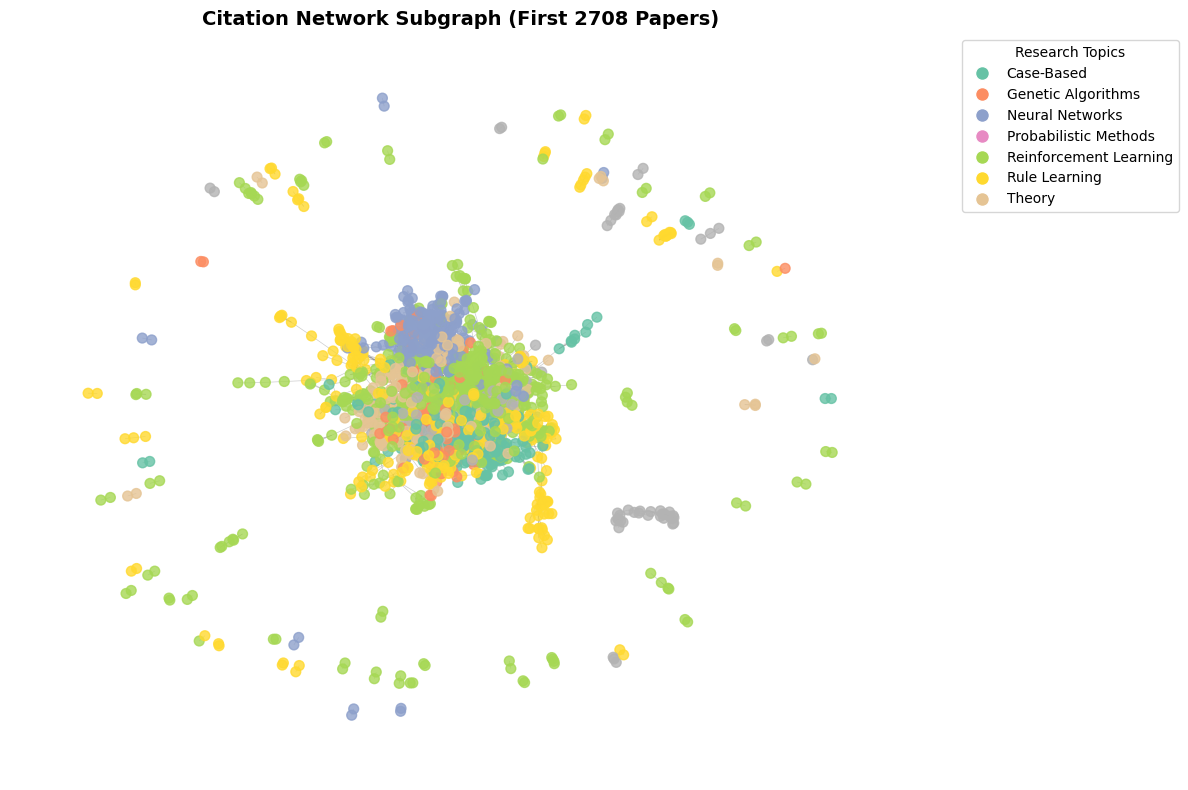

In [ ]:
# Visualize a subgraph of the citation network
def visualize_citation_subgraph(data, num_nodes=100):
    """Visualize a small subgraph of the citation network"""
    # Take first num_nodes nodes
    subgraph_nodes = torch.arange(num_nodes)

    # Create mask for edges between these nodes
    mask = (data.edge_index[0] < num_nodes) & (data.edge_index[1] < num_nodes)
    subgraph_edges = data.edge_index[:, mask]

    # Create subgraph
    subgraph = Data(
        x=data.x[:num_nodes], edge_index=subgraph_edges, y=data.y[:num_nodes]
    )

    # Convert to NetworkX for visualization
    G = to_networkx(subgraph, to_undirected=True)

    # Create visualization
    plt.figure(figsize=(12, 8))

    # Node colors by class
    node_colors = [data.y[i].item() for i in range(num_nodes)]

    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(
        G, pos, node_size=50, node_color=node_colors, cmap=plt.cm.Set2, alpha=0.8
    )
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)

    plt.title(
        f"Citation Network Subgraph (First {num_nodes} Papers)",
        fontsize=14,
        fontweight="bold",
    )
    plt.axis("off")

    # Create legend for classes
    legend_elements = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=plt.cm.Set2(i / 7),
            markersize=10,
            label=class_names[i],
        )
        for i in range(7)
    ]
    plt.legend(
        handles=legend_elements,
        title="Research Topics",
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )

    plt.tight_layout()
    plt.savefig("images/citation_subgraph.png", dpi=150, bbox_inches="tight")
    plt.show()

    return G


# Visualize subgraph
G = visualize_citation_subgraph(data, num_nodes=2708)

## 3. Graph Neural Networks: Core Concepts

### What are GNNs?
Graph Neural Networks extend deep learning to graph-structured data. Unlike CNNs for images or RNNs for sequences, GNNs can handle arbitrary graph structures.

### Key Idea: Message Passing
GNNs work by **aggregating information from neighbors**. Each layer:
1. **Gathers** neighbor features
2. **Aggregates** them (sum, mean, max)
3. **Updates** node representations

### Why GraphSAGE?
We'll use **GraphSAGE** (SAmple and aggreGatE) because:
- **Inductive learning**: Can generalize to unseen nodes
- **Scalability**: Works with large graphs via neighborhood sampling
- **Flexibility**: Can use different aggregation functions

## 4. Model Architecture

We'll implement a **joint model** that solves both tasks simultaneously:

### Model Components:

```
JointGraphModel
├── GraphSAGE Encoder (Shared)
│   ├── SAGEConv Layer 1
│   └── SAGEConv Layer 2
├── Node Classifier
└── Link Predictor
```

### Training Strategy:
1. **Phase 1**: Train for node classification
2. **Phase 2**: Train for link prediction using learned embeddings
3. **Optionally**: Fine-tune jointly

In [9]:
# Define the GraphSAGE encoder
class GraphSAGEEncoder(nn.Module):
    """GraphSAGE encoder for learning node representations"""

    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, edge_index):
        # First SAGE layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        # Second SAGE layer
        x = self.conv2(x, edge_index)

        return x

    def get_embeddings(self, x, edge_index):
        """Get intermediate node embeddings"""
        with torch.no_grad():
            embeddings = self.conv1(x, edge_index)
            embeddings = F.relu(embeddings)
        return embeddings

In [10]:
# Define the Link Predictor
class LinkPredictor(nn.Module):
    """MLP for predicting links between nodes"""

    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.lin1 = nn.Linear(in_channels * 2, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, z, edge_index):
        # Get embeddings for source and destination nodes
        src = z[edge_index[0]]
        dst = z[edge_index[1]]

        # Concatenate and predict
        x = torch.cat([src, dst], dim=1)
        x = self.lin1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.lin2(x)

        return x.squeeze()

In [11]:
# Define the complete joint model
class JointGraphModel(nn.Module):
    """Joint model for node classification and link prediction"""

    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        # Shared encoder
        self.encoder = GraphSAGEEncoder(in_channels, hidden_channels, hidden_channels)

        # Task-specific heads
        self.node_classifier = nn.Linear(hidden_channels, num_classes)
        self.link_predictor = LinkPredictor(hidden_channels, hidden_channels // 2)

    def forward(self, x, edge_index):
        # Get node embeddings
        z = self.encoder(x, edge_index)

        # Node classification
        node_logits = self.node_classifier(z)

        return z, node_logits

    def predict_links(self, z, edge_index):
        """Predict links given node embeddings"""
        return self.link_predictor(z, edge_index)

    def get_embeddings(self, x, edge_index):
        """Get intermediate embeddings"""
        return self.encoder.get_embeddings(x, edge_index)

In [12]:
# Initialize model
model = JointGraphModel(
    in_channels=data.num_features, hidden_channels=128, num_classes=dataset.num_classes
)

print("✅ Model initialized successfully!")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(
    f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}"
)

✅ Model initialized successfully!
Total parameters: 417,288
Trainable parameters: 417,288


## 5. Data Preparation for Link Prediction

For link prediction, we need to:
1. Split edges into train/val/test sets
2. Create negative examples (non-existent edges)
3. Balance positive and negative samples

In [13]:
def prepare_link_prediction_data(data, val_ratio=0.1, test_ratio=0.1):
    """Prepare data for link prediction task"""
    edge_index = data.edge_index

    # Make edges undirected and unique
    row, col = edge_index
    mask = row < col
    row, col = row[mask], col[mask]

    n_edges = row.size(0)

    # Random permutation
    perm = torch.randperm(n_edges)
    row, col = row[perm], col[perm]

    # Split sizes
    n_val = int(n_edges * val_ratio)
    n_test = int(n_edges * test_ratio)

    # Create splits
    val_edges_pos = torch.stack([row[:n_val], col[:n_val]], dim=0)
    test_edges_pos = torch.stack(
        [row[n_val : n_val + n_test], col[n_val : n_val + n_test]], dim=0
    )
    train_edges_pos = torch.stack([row[n_val + n_test :], col[n_val + n_test :]], dim=0)

    # Training edges (all except test)
    train_edge_index = torch.cat([train_edges_pos, val_edges_pos], dim=1)

    print("🔗 Link Prediction Data Split:")
    print(f"  Training edges: {train_edge_index.size(1)}")
    print(f"  Validation positive edges: {val_edges_pos.size(1)}")
    print(f"  Test positive edges: {test_edges_pos.size(1)}")

    return {
        "train_edge_index": train_edge_index,
        "train_edges_pos": train_edges_pos,
        "val_edges_pos": val_edges_pos,
        "test_edges_pos": test_edges_pos,
    }


# Prepare link prediction data
link_data = prepare_link_prediction_data(data)

🔗 Link Prediction Data Split:
  Training edges: 4751
  Validation positive edges: 527
  Test positive edges: 527


## 6. Training Functions

In [14]:
def train_node_classification(model, data, optimizer, criterion, epochs=200):
    """Train model for node classification"""
    train_losses, val_accs = [], []
    best_val_acc = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        _, node_logits = model(data.x, data.edge_index)

        # Compute loss on training nodes only
        loss = criterion(node_logits[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            _, val_logits = model(data.x, data.edge_index)
            val_pred = val_logits[data.val_mask].argmax(dim=1)
            val_acc = (val_pred == data.y[data.val_mask]).float().mean().item()

        train_losses.append(loss.item())
        val_accs.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc

        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1:03d}: Loss={loss.item():.4f}, Val Acc={val_acc:.4f}")

    return train_losses, val_accs

In [15]:
def train_link_prediction(model, data, link_data, optimizer, criterion, epochs=100):
    """Train model for link prediction"""
    train_losses = []

    # Prepare training data
    pos_edges = link_data["train_edges_pos"]

    # Create negative samples
    neg_edges = negative_sampling(
        edge_index=link_data["train_edge_index"],
        num_nodes=data.num_nodes,
        num_neg_samples=pos_edges.size(1),
    )

    # Combine positive and negative edges
    train_edges = torch.cat([pos_edges, neg_edges], dim=1)
    train_labels = torch.cat(
        [torch.ones(pos_edges.size(1)), torch.zeros(neg_edges.size(1))]
    ).to(data.x.device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Get embeddings
        z, _ = model(data.x, link_data["train_edge_index"])

        # Predict links
        link_scores = model.predict_links(z, train_edges)

        # Compute loss
        loss = criterion(link_scores, train_labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if (epoch + 1) % 20 == 0:
            print(f"Link Epoch {epoch+1:03d}: Loss={loss.item():.4f}")

    return train_losses

In [16]:
def evaluate_model(model, data, link_data):
    """Comprehensive evaluation of both tasks"""
    model.eval()

    with torch.no_grad():
        # Node Classification Evaluation
        _, node_logits = model(data.x, data.edge_index)
        test_pred = node_logits[data.test_mask].argmax(dim=1)
        node_acc = (test_pred == data.y[data.test_mask]).float().mean().item()

        # Link Prediction Evaluation
        z, _ = model(data.x, link_data["train_edge_index"])

        # Positive test edges
        pos_edges = link_data["test_edges_pos"]
        pos_scores = torch.sigmoid(model.predict_links(z, pos_edges))

        # Negative test edges
        neg_edges = negative_sampling(
            edge_index=torch.cat(
                [link_data["train_edge_index"], link_data["val_edges_pos"]], dim=1
            ),
            num_nodes=data.num_nodes,
            num_neg_samples=pos_edges.size(1),
        )
        neg_scores = torch.sigmoid(model.predict_links(z, neg_edges))

        # Combine predictions
        all_scores = torch.cat([pos_scores, neg_scores]).cpu().numpy()
        all_labels = (
            torch.cat([torch.ones(pos_scores.size(0)), torch.zeros(neg_scores.size(0))])
            .cpu()
            .numpy()
        )

        # Compute metrics
        auc = roc_auc_score(all_labels, all_scores)
        ap = average_precision_score(all_labels, all_scores)

        # Precision@k
        k = min(100, len(all_scores) // 2)
        top_k_idx = np.argsort(all_scores)[-k:]
        precision_at_k = all_labels[top_k_idx].mean()

    return {
        "node_accuracy": node_acc,
        "link_auc": auc,
        "link_ap": ap,
        "link_precision_at_k": precision_at_k,
    }

## 7. Training Pipeline

In [17]:
def train_joint_model(model, data, link_data, epochs_node=100, epochs_link=50):
    """Complete training pipeline for joint model"""
    print("=" * 60)
    print("STARTING TRAINING PIPELINE")
    print("=" * 60)

    # Device setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    data = data.to(device)

    # Phase 1: Node Classification
    print("\n📚 PHASE 1: Training Node Classification")
    print("-" * 40)

    optimizer1 = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion1 = nn.CrossEntropyLoss()

    node_losses, node_accs = train_node_classification(
        model, data, optimizer1, criterion1, epochs_node
    )

    # Phase 2: Link Prediction
    print("\n🔗 PHASE 2: Training Link Prediction")
    print("-" * 40)

    optimizer2 = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion2 = nn.BCEWithLogitsLoss()

    link_losses = train_link_prediction(
        model, data, link_data, optimizer2, criterion2, epochs_link
    )

    # Evaluation
    print("\n📊 FINAL EVALUATION")
    print("-" * 40)

    metrics = evaluate_model(model, data, link_data)

    print(f"Node Classification Accuracy: {metrics['node_accuracy']:.4f}")
    print(f"Link Prediction AUC-ROC: {metrics['link_auc']:.4f}")
    print(f"Link Prediction Average Precision: {metrics['link_ap']:.4f}")
    print(f"Link Prediction Precision@100: {metrics['link_precision_at_k']:.4f}")

    return node_losses, node_accs, link_losses, metrics

In [18]:
# Run training
node_losses, node_accs, link_losses, metrics = train_joint_model(
    model, data, link_data, epochs_node=100, epochs_link=50
)

STARTING TRAINING PIPELINE

📚 PHASE 1: Training Node Classification
----------------------------------------
Epoch 020: Loss=0.0000, Val Acc=0.7440
Epoch 040: Loss=0.0021, Val Acc=0.6920
Epoch 060: Loss=0.0021, Val Acc=0.6980
Epoch 080: Loss=0.0017, Val Acc=0.6980
Epoch 100: Loss=0.0003, Val Acc=0.6940

🔗 PHASE 2: Training Link Prediction
----------------------------------------
Link Epoch 020: Loss=0.2875
Link Epoch 040: Loss=0.1088

📊 FINAL EVALUATION
----------------------------------------
Node Classification Accuracy: 0.3180
Link Prediction AUC-ROC: 0.8098
Link Prediction Average Precision: 0.8028
Link Prediction Precision@100: 0.9300


## 8. Results Visualization

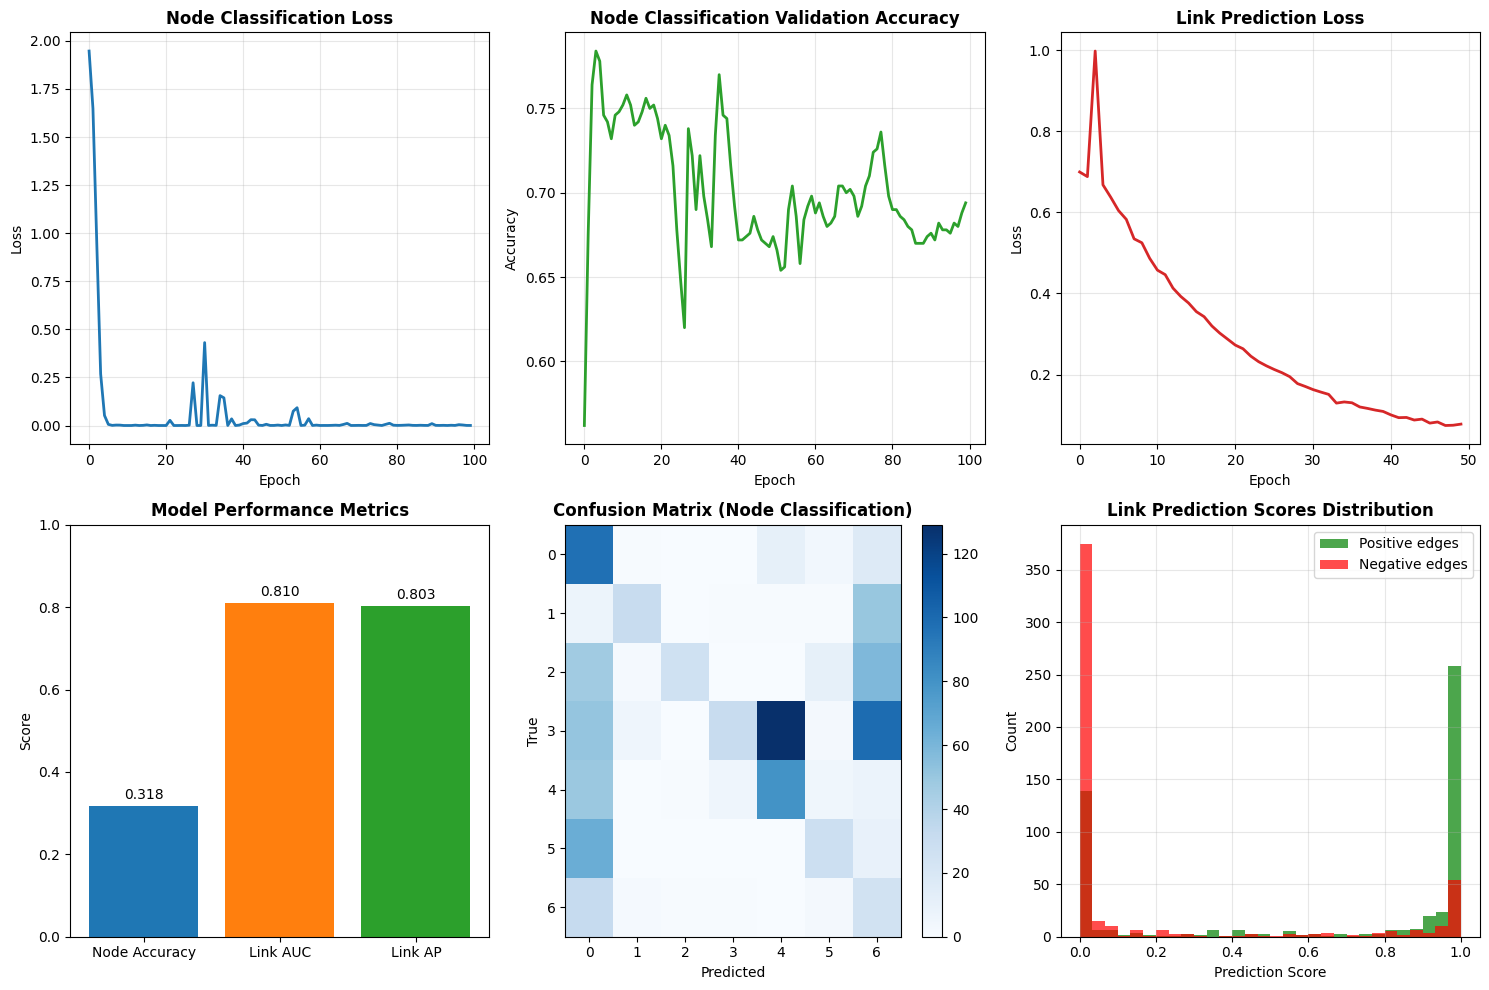

In [ ]:
def plot_training_results(node_losses, node_accs, link_losses, metrics):
    """Plot training results and metrics"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Node classification loss
    axes[0, 0].plot(node_losses, color="tab:blue", linewidth=2)
    axes[0, 0].set_title("Node Classification Loss", fontsize=12, fontweight="bold")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Loss")
    axes[0, 0].grid(True, alpha=0.3)

    # Node classification accuracy
    axes[0, 1].plot(node_accs, color="tab:green", linewidth=2)
    axes[0, 1].set_title(
        "Node Classification Validation Accuracy", fontsize=12, fontweight="bold"
    )
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel("Accuracy")
    axes[0, 1].grid(True, alpha=0.3)

    # Link prediction loss
    axes[0, 2].plot(link_losses, color="tab:red", linewidth=2)
    axes[0, 2].set_title("Link Prediction Loss", fontsize=12, fontweight="bold")
    axes[0, 2].set_xlabel("Epoch")
    axes[0, 2].set_ylabel("Loss")
    axes[0, 2].grid(True, alpha=0.3)

    # Metrics comparison
    metric_names = ["Node Accuracy", "Link AUC", "Link AP"]
    metric_values = [metrics["node_accuracy"], metrics["link_auc"], metrics["link_ap"]]
    colors = ["tab:blue", "tab:orange", "tab:green"]

    bars = axes[1, 0].bar(metric_names, metric_values, color=colors)
    axes[1, 0].set_title("Model Performance Metrics", fontsize=12, fontweight="bold")
    axes[1, 0].set_ylabel("Score")
    axes[1, 0].set_ylim([0, 1])

    # Add value labels on bars
    for bar, value in zip(bars, metric_values):
        height = bar.get_height()
        axes[1, 0].text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.01,
            f"{value:.3f}",
            ha="center",
            va="bottom",
        )

    # Confusion matrix for node classification
    model.eval()
    with torch.no_grad():
        _, node_logits = model(data.x, data.edge_index)
        test_pred = node_logits[data.test_mask].argmax(dim=1).cpu().numpy()
        test_true = data.y[data.test_mask].cpu().numpy()

    cm = confusion_matrix(test_true, test_pred)

    im = axes[1, 1].imshow(cm, cmap="Blues", aspect="auto")
    axes[1, 1].set_title(
        "Confusion Matrix (Node Classification)", fontsize=12, fontweight="bold"
    )
    axes[1, 1].set_xlabel("Predicted")
    axes[1, 1].set_ylabel("True")
    plt.colorbar(im, ax=axes[1, 1])

    # Link prediction scores distribution
    with torch.no_grad():
        z, _ = model(data.x, link_data["train_edge_index"])
        pos_edges = link_data["test_edges_pos"]
        neg_edges = negative_sampling(
            edge_index=torch.cat(
                [link_data["train_edge_index"], link_data["val_edges_pos"]], dim=1
            ),
            num_nodes=data.num_nodes,
            num_neg_samples=pos_edges.size(1),
        )

        pos_scores = torch.sigmoid(model.predict_links(z, pos_edges)).cpu().numpy()
        neg_scores = torch.sigmoid(model.predict_links(z, neg_edges)).cpu().numpy()

    axes[1, 2].hist(
        pos_scores, bins=30, alpha=0.7, label="Positive edges", color="green"
    )
    axes[1, 2].hist(neg_scores, bins=30, alpha=0.7, label="Negative edges", color="red")
    axes[1, 2].set_title(
        "Link Prediction Scores Distribution", fontsize=12, fontweight="bold"
    )
    axes[1, 2].set_xlabel("Prediction Score")
    axes[1, 2].set_ylabel("Count")
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(
        "images/training_results_comprehensive.png", dpi=150, bbox_inches="tight"
    )
    plt.show()


# Plot results
plot_training_results(node_losses, node_accs, link_losses, metrics)

## 9. Model Interpretation and Analysis

  File "c:\Users\troye\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\troye\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\troye\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1028, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\troye\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1540, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


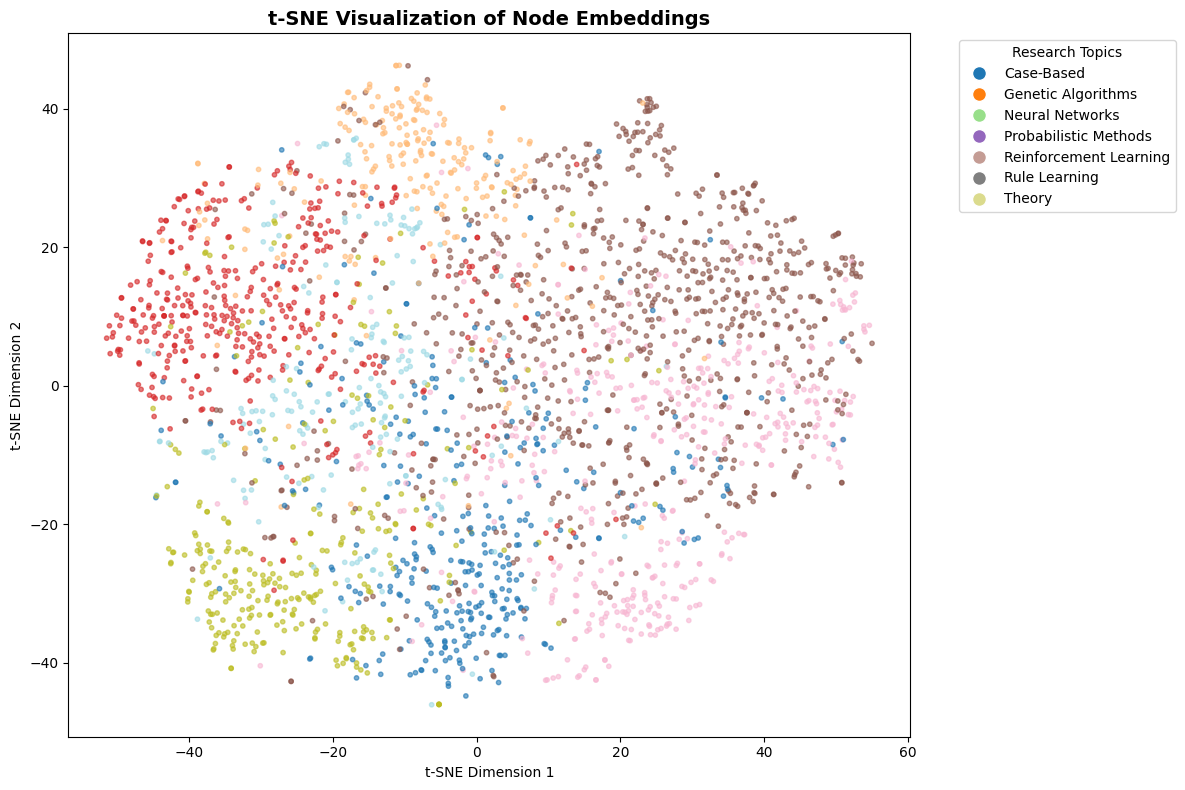

In [ ]:
def visualize_node_embeddings(model, data):
    """Visualize learned node embeddings using t-SNE"""
    model.eval()
    with torch.no_grad():
        # Get embeddings
        embeddings = model.get_embeddings(data.x, data.edge_index).cpu().numpy()
        labels = data.y.cpu().numpy()

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        embeddings_2d[:, 0],
        embeddings_2d[:, 1],
        c=labels,
        cmap="tab20",
        alpha=0.6,
        s=10,
    )

    plt.title("t-SNE Visualization of Node Embeddings", fontsize=14, fontweight="bold")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")

    # Create legend
    legend_elements = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=plt.cm.tab20(i / 7),
            markersize=10,
            label=class_names[i],
        )
        for i in range(7)
    ]
    plt.legend(
        handles=legend_elements,
        title="Research Topics",
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )

    plt.tight_layout()
    plt.savefig("images/tsne_embeddings.png", dpi=150, bbox_inches="tight")
    plt.show()

    return embeddings_2d


# Visualize embeddings
embeddings_2d = visualize_node_embeddings(model, data)

In [21]:
def analyze_model_predictions(model, data, link_data, num_examples=5):
    """Analyze and explain model predictions"""
    model.eval()

    print("🔍 MODEL PREDICTION ANALYSIS")
    print("=" * 60)

    # Node classification examples
    print("\n📄 Node Classification Examples:")
    print("-" * 40)

    with torch.no_grad():
        _, node_logits = model(data.x, data.edge_index)
        predictions = node_logits.argmax(dim=1)
        probabilities = F.softmax(node_logits, dim=1)

    for i in range(num_examples):
        true_class = data.y[i].item()
        pred_class = predictions[i].item()
        confidence = probabilities[i][pred_class].item()

        print(f"Paper {i}:")
        print(f"  True topic: {class_names[true_class]}")
        print(f"  Predicted: {class_names[pred_class]} (confidence: {confidence:.2%})")
        print(f"  {'✓ CORRECT' if true_class == pred_class else '✗ WRONG'}")
        print()

    # Link prediction examples
    print("\n🔗 Link Prediction Examples:")
    print("-" * 40)

    with torch.no_grad():
        z, _ = model(data.x, link_data["train_edge_index"])

        # Test some specific paper pairs
        test_pairs = torch.tensor(
            [
                [0, 10, 50, 100, 200],  # Source papers
                [5, 15, 55, 105, 205],  # Target papers
            ]
        )

        scores = torch.sigmoid(model.predict_links(z, test_pairs))

    for i in range(test_pairs.size(1)):
        src = test_pairs[0, i].item()
        dst = test_pairs[1, i].item()
        score = scores[i].item()

        src_topic = class_names[data.y[src].item()]
        dst_topic = class_names[data.y[dst].item()]

        print(f"Citation from Paper {src} ({src_topic}) to Paper {dst} ({dst_topic}):")
        print(f"  Prediction score: {score:.3f}")
        print(
            f"  Interpretation: {'Likely citation' if score > 0.5 else 'Unlikely citation'}"
        )
        print()


# Analyze predictions
analyze_model_predictions(model, data, link_data, num_examples=5)

🔍 MODEL PREDICTION ANALYSIS

📄 Node Classification Examples:
----------------------------------------
Paper 0:
  True topic: Probabilistic Methods
  Predicted: Reinforcement Learning (confidence: 74.25%)
  ✗ WRONG

Paper 1:
  True topic: Reinforcement Learning
  Predicted: Reinforcement Learning (confidence: 99.84%)
  ✓ CORRECT

Paper 2:
  True topic: Reinforcement Learning
  Predicted: Reinforcement Learning (confidence: 100.00%)
  ✓ CORRECT

Paper 3:
  True topic: Case-Based
  Predicted: Case-Based (confidence: 99.55%)
  ✓ CORRECT

Paper 4:
  True topic: Probabilistic Methods
  Predicted: Theory (confidence: 99.48%)
  ✗ WRONG


🔗 Link Prediction Examples:
----------------------------------------
Citation from Paper 0 (Probabilistic Methods) to Paper 5 (Neural Networks):
  Prediction score: 0.000
  Interpretation: Unlikely citation

Citation from Paper 10 (Case-Based) to Paper 15 (Probabilistic Methods):
  Prediction score: 0.000
  Interpretation: Unlikely citation

Citation from Pape

# 10. Practical Applications

In [22]:
def recommend_citations(model, data, link_data, paper_id, top_k=5):
    """Recommend citations for a given paper"""
    model.eval()

    with torch.no_grad():
        # Get embeddings
        z, _ = model(data.x, link_data["train_edge_index"])

        # Get paper embedding
        paper_embedding = z[paper_id]

        # Calculate similarity with all other papers
        similarities = F.cosine_similarity(paper_embedding.unsqueeze(0), z, dim=1)

        # Get existing citations
        existing_citations = data.edge_index[1][data.edge_index[0] == paper_id]

        # Find top candidates (excluding existing citations and self)
        candidates = []
        for i in range(data.num_nodes):
            if i != paper_id and i not in existing_citations:
                candidates.append((i, similarities[i].item()))

        # Sort by similarity
        candidates.sort(key=lambda x: x[1], reverse=True)
        top_candidates = candidates[:top_k]

    print(f"\n📚 Citation Recommendations for Paper {paper_id}:")
    print(f"Topic: {class_names[data.y[paper_id].item()]}")
    print("-" * 60)

    for rank, (cand_id, similarity) in enumerate(top_candidates, 1):
        cand_topic = class_names[data.y[cand_id].item()]
        print(f"{rank}. Paper {cand_id} ({cand_topic})")
        print(f"   Similarity score: {similarity:.3f}")
        print(
            f"   Potential citation strength: {'High' if similarity > 0.5 else 'Medium'}"
        )
        print()

    return top_candidates


# Example: Get citation recommendations for paper 42
recommendations = recommend_citations(model, data, link_data, paper_id=42, top_k=5)


📚 Citation Recommendations for Paper 42:
Topic: Theory
------------------------------------------------------------
1. Paper 244 (Neural Networks)
   Similarity score: 0.940
   Potential citation strength: High

2. Paper 346 (Neural Networks)
   Similarity score: 0.932
   Potential citation strength: High

3. Paper 31 (Theory)
   Similarity score: 0.931
   Potential citation strength: High

4. Paper 189 (Neural Networks)
   Similarity score: 0.930
   Potential citation strength: High

5. Paper 757 (Neural Networks)
   Similarity score: 0.926
   Potential citation strength: High



## 11. Advanced: Hyperparameter Tuning

In [23]:
def hyperparameter_tuning(data, link_data):
    """Experiment with different hyperparameters"""
    results = []

    # Different hidden dimensions to try
    hidden_dims = [64, 128, 256]
    learning_rates = [0.01, 0.005, 0.001]

    print("🔧 Hyperparameter Tuning Experiments")
    print("=" * 60)

    for hidden_dim in hidden_dims:
        for lr in learning_rates:
            print(f"\nTesting: hidden_dim={hidden_dim}, lr={lr}")
            print("-" * 40)

            # Initialize new model
            model_tune = JointGraphModel(
                in_channels=data.num_features,
                hidden_channels=hidden_dim,
                num_classes=dataset.num_classes,
            ).to(data.x.device)

            # Train
            optimizer = torch.optim.Adam(
                model_tune.parameters(), lr=lr, weight_decay=5e-4
            )
            criterion = nn.CrossEntropyLoss()

            # Quick training for tuning
            train_losses, _ = train_node_classification(
                model_tune, data, optimizer, criterion, epochs=50
            )

            # Evaluate
            metrics = evaluate_model(model_tune, data, link_data)

            results.append(
                {
                    "hidden_dim": hidden_dim,
                    "learning_rate": lr,
                    "node_accuracy": metrics["node_accuracy"],
                    "link_auc": metrics["link_auc"],
                }
            )

            print(
                f"Results: Acc={metrics['node_accuracy']:.3f}, AUC={metrics['link_auc']:.3f}"
            )

    # Find best configuration
    best_result = max(results, key=lambda x: x["node_accuracy"])

    print("\n" + "=" * 60)
    print("🎯 BEST CONFIGURATION FOUND:")
    print(f"Hidden dimensions: {best_result['hidden_dim']}")
    print(f"Learning rate: {best_result['learning_rate']}")
    print(f"Node accuracy: {best_result['node_accuracy']:.3f}")
    print(f"Link AUC: {best_result['link_auc']:.3f}")
    print("=" * 60)

    return results, best_result

tuning_results, best_config = hyperparameter_tuning(data, link_data)

🔧 Hyperparameter Tuning Experiments

Testing: hidden_dim=64, lr=0.01
----------------------------------------
Epoch 020: Loss=0.0000, Val Acc=0.7520
Epoch 040: Loss=0.0194, Val Acc=0.7400
Results: Acc=0.763, AUC=0.456

Testing: hidden_dim=64, lr=0.005
----------------------------------------
Epoch 020: Loss=0.0006, Val Acc=0.7660
Epoch 040: Loss=0.0001, Val Acc=0.7500
Results: Acc=0.780, AUC=0.546

Testing: hidden_dim=64, lr=0.001
----------------------------------------
Epoch 020: Loss=1.0243, Val Acc=0.7580
Epoch 040: Loss=0.1163, Val Acc=0.7600
Results: Acc=0.790, AUC=0.532

Testing: hidden_dim=128, lr=0.01
----------------------------------------
Epoch 020: Loss=0.0084, Val Acc=0.7220
Epoch 040: Loss=0.0267, Val Acc=0.6420
Results: Acc=0.723, AUC=0.426

Testing: hidden_dim=128, lr=0.005
----------------------------------------
Epoch 020: Loss=0.0006, Val Acc=0.7640
Epoch 040: Loss=0.0000, Val Acc=0.7600
Results: Acc=0.760, AUC=0.467

Testing: hidden_dim=128, lr=0.001
--------------

## 12. Model Saving and Loading

In [24]:
def save_model(model, path="joint_graph_model.pth"):
    """Save model to file"""
    torch.save(
        {
            "model_state_dict": model.state_dict(),
            "model_config": {
                "in_channels": data.num_features,
                "hidden_channels": 128,
                "num_classes": dataset.num_classes,
            },
        },
        path,
    )
    print(f"✅ Model saved to {path}")


def load_model(path="joint_graph_model.pth"):
    """Load model from file"""
    checkpoint = torch.load(path)

    model = JointGraphModel(
        in_channels=checkpoint["model_config"]["in_channels"],
        hidden_channels=checkpoint["model_config"]["hidden_channels"],
        num_classes=checkpoint["model_config"]["num_classes"],
    )

    model.load_state_dict(checkpoint["model_state_dict"])
    print(f"✅ Model loaded from {path}")

    return model


# Save the trained model
save_model(model)

✅ Model saved to joint_graph_model.pth
